# Fe statistic implementation from ee

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import scipy.linalg as sl
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)
import matplotlib.pyplot as plt

class FeStat(object):
    """
    Class for the Fe-statistic.

    :param psrs: List of `enterprise` Pulsar instances.
    :param params: Dictionary of noise parameters.

    """

    def __init__(self, psrs, params=None):

#         print('Initializing the model...')

        efac = parameter.Constant()
        equad = parameter.Constant()
        ef = white_signals.MeasurementNoise(efac=efac)
        # eq = white_signals.EquadNoise(log10_equad=equad)

        tm = gp_signals.TimingModel(use_svd=True)

        s =  ef + tm

        model = []
        for p in psrs:
            model.append(s(p))
        self.pta = signal_base.PTA(model)

        # set white noise parameters
        if params is None:
            print('No noise dictionary provided!...')
        else:
            self.pta.set_default_params(params)

        self.psrs = psrs
        self.params = params

        self.Nmats = None

    def get_Nmats(self):
        '''Makes the Nmatrix used in the fstatistic'''
        TNTs = self.pta.get_TNT(self.params)
        phiinvs = self.pta.get_phiinv(self.params, logdet=False, method='partition')
        # Get noise parameters for pta toaerr**2
        Nvecs = self.pta.get_ndiag(self.params)
        # Get the basis matrix
        Ts = self.pta.get_basis(self.params)

        Nmats = [make_Nmat(phiinv, TNT, Nvec, T) for phiinv, TNT, Nvec, T in zip(phiinvs, TNTs, Nvecs, Ts)]

        return Nmats
    
    def compute_Fe_bwm(self, t0, gw_skylocs, brave=False, maximized_parameters=False):
        """
        Computes the Fe-statistic for BWMs analagous to the Fe-statistic for CWs(see Ellis, Siemens, Creighton 2012).

        :param t0_mjd: epoch of memory event (MJD)
        :param gw_skyloc: 2x{number of sky locations} array containing [theta, phi] for each queried sky location,
                          where theta=pi/2-DEC, phi=RA,
                          for single sky location use gw_skyloc= np.array([[theta,],[phi,]])
        :param brave: Skip sanity checks in linalg for speedup if True.
        :param maximized_parameters: Calculate maximized extrinsic parameters if True.

        :returns:
            fstat: value of the Fe-statistic
        :if maximized_parameters=True also returns:
            inc_max: Maximized value of inclination
            psi_max: Maximized value of polarization angle
            phase0_max: Maximized value of initial fhase
            h_max: Maximized value of amplitude

        """
        phiinvs = self.pta.get_phiinv(self.params, logdet=False)
        TNTs = self.pta.get_TNT(self.params)
        Ts = self.pta.get_basis()
        
        t0_sec = t0

        if self.Nmats is None:

            self.Nmats = self.get_Nmats()

        n_psr = len(self.psrs)
        
        # we only need two basis functions for each pulsar, the plus and cross response basis
        N = np.zeros((n_psr, 2))
        M = np.zeros((n_psr, 2, 2))
        
        for idx, (psr, Nmat, TNT, phiinv, T) in enumerate(zip(self.psrs, self.Nmats,
                                                              TNTs, phiinvs, Ts)):                                                      

            Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)

            ntoa = len(psr.toas)

            # populate these with the right signal templates
            # Since we multiply by the Fp and Fc antenna patterns later, we just populate these with
            # the the time-dependent shapes
            psr_bwm_template = np.zeros(len(psr.toas))
            for toa_idx, toa in enumerate(psr.toas):
                if toa > t0_sec:               
                    psr_bwm_template[toa_idx] = toa - t0_sec
            A = np.zeros((2, ntoa))
            A[0, :] = psr_bwm_template
            A[1, :] = psr_bwm_template
            
#             plt.plot(psr.toas, A[0,:], label='A0')
#             plt.plot(psr.toas, A[1,:], label='A1')
#             plt.legend()
#             plt.show()

            # compute inner products of the residuals with templates.
            # see Eq [36] in Ellis et al 2018. These correspond to N1 and N2
            ip1 = innerProduct_rr(A[0, :], psr.residuals, Nmat, T, Sigma, brave=False)
            ip2 = innerProduct_rr(A[1, :], psr.residuals, Nmat, T, Sigma, brave=False)
            
#             print(ip1)
#             print(ip2)
            
            N[idx, :] = np.array([ip1, ip2])
            
            # define M matrix M_ij=(A_i|A_j)
            for jj in range(2):
                for kk in range(2):
                    M[idx, jj, kk] = innerProduct_rr(A[jj, :], A[kk, :], Nmat, T, Sigma, brave=brave)
#             print(M[idx])
        fstat = np.zeros(gw_skylocs.shape[0])
#         print(fstat.shape)

        for j, gw_pos in enumerate(gw_skylocs):
#             print("GW skyloc {}".format(int(j)))
            # Need to add Fp and Fc 
            NN = np.copy(N)
            MM = np.copy(M)
#             print(gw_pos)
            for idx, psr in enumerate(self.psrs):
                F_p, F_c, _ = utils.create_gw_antenna_pattern(psr.pos, gw_pos[0], gw_pos[1])
                NN[idx, :] *= np.array([F_p, F_c]) # in the (A|r) products, only one factor of the antenna patterns
                
                #MM[idx, :, :] *= np.array([[F_p**2, F_p**2, F_p*F_c, F_p*F_c],
                #                           [F_p**2, F_p**2, F_p*F_c, F_p*F_c],
                #                           [F_p*F_c, F_p*F_c, F_c**2, F_c**2],
                #                           [F_p*F_c, F_p*F_c, F_c**2, F_c**2]])
                
                
                # I think the structure of MM for BWMs ought to look something like:
                MM[idx, :, :] *= np.array([[F_p**2, F_p*F_c],
                                          [F_p*F_c, F_c**2]])

            #Total Mij ought to just be the sum of each pulsar's Ms
            M_sum = np.sum(MM, axis=0)
            N_sum = np.sum(NN, axis=0)
            
            M_inv = np.linalg.pinv(M_sum) #we expect this ought to be invertible for any PTA with 2+ psrs
            
            #fstat computation
            fstat[j] = 0.5 * np.dot(N_sum, np.dot(M_inv, N_sum))
            
            return fstat
            
    def compute_Fe(self, f0, gw_skyloc, brave=False, maximized_parameters=False):
        """
        Computes the Fe-statistic (see Ellis, Siemens, Creighton 2012).

        :param f0: GW frequency
        :param gw_skyloc: 2x{number of sky locations} array containing [theta, phi] for each queried sky location,
                          where theta=pi/2-DEC, phi=RA,
                          for singlge sky location use gw_skyloc= np.array([[theta,],[phi,]])
        :param brave: Skip sanity checks in linalg for speedup if True.
        :param maximized_parameters: Calculate maximized extrinsic parameters if True.

        :returns:
            fstat: value of the Fe-statistic
        :if maximized_parameters=True also returns:
            inc_max: Maximized value of inclination
            psi_max: Maximized value of polarization angle
            phase0_max: Maximized value of initial fhase
            h_max: Maximized value of amplitude

        """

        tref=53000*86400

        phiinvs = self.pta.get_phiinv(self.params, logdet=False)
        TNTs = self.pta.get_TNT(self.params)
        Ts = self.pta.get_basis()

        if self.Nmats is None:

            self.Nmats = self.get_Nmats()

        n_psr = len(self.psrs)
        N = np.zeros((n_psr, 4))
        M = np.zeros((n_psr, 4, 4))

        for idx, (psr, Nmat, TNT, phiinv, T) in enumerate(zip(self.psrs, self.Nmats,
                                                              TNTs, phiinvs, Ts)):

            Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)

            ntoa = len(psr.toas)

            A = np.zeros((4, ntoa))
            A[0, :] = 1 / f0 ** (1 / 3) * np.sin(2 * np.pi * f0 * (psr.toas-tref))
            A[1, :] = 1 / f0 ** (1 / 3) * np.cos(2 * np.pi * f0 * (psr.toas-tref))
            A[2, :] = 1 / f0 ** (1 / 3) * np.sin(2 * np.pi * f0 * (psr.toas-tref))
            A[3, :] = 1 / f0 ** (1 / 3) * np.cos(2 * np.pi * f0 * (psr.toas-tref))

            ip1 = innerProduct_rr(A[0, :], psr.residuals, Nmat, T, Sigma, brave=brave)
            ip2 = innerProduct_rr(A[1, :], psr.residuals, Nmat, T, Sigma, brave=brave)
            ip3 = innerProduct_rr(A[2, :], psr.residuals, Nmat, T, Sigma, brave=brave)
            ip4 = innerProduct_rr(A[3, :], psr.residuals, Nmat, T, Sigma, brave=brave)

            N[idx, :] = np.array([ip1, ip2, ip3, ip4])

            # define M matrix M_ij=(A_i|A_j)
            for jj in range(4):
                for kk in range(4):
                    M[idx, jj, kk] = innerProduct_rr(A[jj, :], A[kk, :], Nmat, T, Sigma, brave=brave)

        fstat = np.zeros(gw_skyloc.shape[1])
        print(fstat.shape)
        if maximized_parameters:
            inc_max = np.zeros(gw_skyloc.shape[1])
            psi_max = np.zeros(gw_skyloc.shape[1])
            phase0_max = np.zeros(gw_skyloc.shape[1])
            h_max = np.zeros(gw_skyloc.shape[1])

        for j, gw_pos in enumerate(gw_skyloc.T):
            NN = np.copy(N)
            MM = np.copy(M)
            for idx, psr in enumerate(self.psrs):
                F_p, F_c, _ = utils.create_gw_antenna_pattern(psr.pos, gw_pos[0], gw_pos[1])
                NN[idx, :] *= np.array([F_p, F_p, F_c, F_c])
                MM[idx, :, :] *= np.array([[F_p**2, F_p**2, F_p*F_c, F_p*F_c],
                                           [F_p**2, F_p**2, F_p*F_c, F_p*F_c],
                                           [F_p*F_c, F_p*F_c, F_c**2, F_c**2],
                                           [F_p*F_c, F_p*F_c, F_c**2, F_c**2]])

            N_sum = np.sum(NN, axis=0)
            M_sum = np.sum(MM, axis=0)

            # take inverse of M
            Minv = np.linalg.pinv(M_sum)

            fstat[j] = 0.5 * np.dot(N_sum, np.dot(Minv, N_sum))

            if maximized_parameters:
                a_hat = np.dot(Minv, N_sum)

                A_p = (np.sqrt((a_hat[0]+a_hat[3])**2 + (a_hat[1]-a_hat[2])**2) +
                       np.sqrt((a_hat[0]-a_hat[3])**2 + (a_hat[1]+a_hat[2])**2))
                A_c = (np.sqrt((a_hat[0]+a_hat[3])**2 + (a_hat[1]-a_hat[2])**2) -
                       np.sqrt((a_hat[0]-a_hat[3])**2 + (a_hat[1]+a_hat[2])**2))
                AA = A_p + np.sqrt(A_p**2 - A_c**2)
                # AA = A_p + np.sqrt(A_p**2 + A_c**2)

                # inc_max[j] = np.arccos(-A_c/AA)
                inc_max[j] = np.arccos(A_c/AA)

                two_psi_max = np.arctan2((A_p*a_hat[3] - A_c*a_hat[0]),
                                         (A_c*a_hat[2] + A_p*a_hat[1]))

                psi_max[j]=0.5*np.arctan2(np.sin(two_psi_max),
                                          -np.cos(two_psi_max))

                # convert from [-pi, pi] convention to [0,2*pi] convention
                if psi_max[j]<0:
                    psi_max[j]+=np.pi

                # correcting weird problem of degeneracy (psi-->pi-psi/2 and phi0-->2pi-phi0 keep everything the same)
                if psi_max[j]>np.pi/2:
                    psi_max[j]+= -np.pi/2

                half_phase0 = -0.5*np.arctan2(A_p*a_hat[3] - A_c*a_hat[0],
                                              A_c*a_hat[1] + A_p*a_hat[2])

                phase0_max[j] = np.arctan2(-np.sin(2*half_phase0),
                                           np.cos(2*half_phase0))

                # convert from [-pi, pi] convention to [0,2*pi] convention
                if phase0_max[j]<0:
                    phase0_max[j]+=2*np.pi

                zeta = np.abs(AA)/4  # related to amplitude, zeta=M_chirp^(5/3)/D
                h_max[j] = zeta * 2 * (np.pi*f0)**(2/3)*np.pi**(1/3)

        if maximized_parameters:
            return fstat, inc_max, psi_max, phase0_max, h_max
        else:
            return fstat


def innerProduct_rr(x, y, Nmat, Tmat, Sigma, TNx=None, TNy=None, brave=False):
    r"""
        Compute inner product using rank-reduced
        approximations for red noise/jitter
        Compute: x^T N^{-1} y - x^T N^{-1} T \Sigma^{-1} T^T N^{-1} y

        :param x: vector timeseries 1
        :param y: vector timeseries 2
        :param Nmat: white noise matrix
        :param Tmat: Modified design matrix including red noise/jitter
        :param Sigma: Sigma matrix (\varphi^{-1} + T^T N^{-1} T)
        :param TNx: T^T N^{-1} x precomputed
        :param TNy: T^T N^{-1} y precomputed
        :return: inner product (x|y)
        """

    # white noise term
    Ni = Nmat
    xNy = np.dot(np.dot(x, Ni), y)
    Nx, Ny = np.dot(Ni, x), np.dot(Ni, y)

    if TNx is None and TNy is None:
        TNx = np.dot(Tmat.T, Nx)
        TNy = np.dot(Tmat.T, Ny)

    if brave:
        cf = sl.cho_factor(Sigma, check_finite=False)
        SigmaTNy = sl.cho_solve(cf, TNy, check_finite=False)
    else:
        cf = sl.cho_factor(Sigma)
        SigmaTNy = sl.cho_solve(cf, TNy)

    ret = xNy - np.dot(TNx, SigmaTNy)

    return ret


def make_Nmat(phiinv, TNT, Nvec, T):

    Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
    cf = sl.cho_factor(Sigma)
    # Nshape = np.shape(T)[0] # Not currently used in code

    TtN = np.multiply((1/Nvec)[:, None], T).T

    # Put pulsar's autoerrors in a diagonal matrix
    Ndiag = np.diag(1/Nvec)

    expval2 = sl.cho_solve(cf, TtN)
    # TtNt = np.transpose(TtN) # Not currently used in code

    # An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
    return Ndiag - np.dot(TtN.T, expval2)

# Let's try this on a data set

In [2]:
import pickle
import numpy as np

nano12p5_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12p5_pkl, 'rb') as pklin:
    allpsrs = pickle.load(pklin)
    
testpsr = allpsrs[0]
psrnames = [p.name for p in allpsrs[0:4]]

In [6]:
# We know the injected WN values
fake_noisedict = {}
for psrname in psrnames:
    fake_noisedict['{}_efac'.format(psrname)] = 1.0
    # fake_noisedict['{}_log10_equad'.format(psrname)] = np.log10(200e-9)

In [15]:
fes_wn = []

In [ ]:
from enterprise.pulsar import Pulsar


partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/'

burst_epoch = (53000 + 365.25*6) * 24*3600
for realization in range(1, 500):
    realization_psrs = []
    for psrname in psrnames:
        parfile = partim_dir + '{}/{}.par'.format(realization, psrname)
        timfile = partim_dir + '{}/{}.tim'.format(realization, psrname)
        
        realization_psrs.append(Pulsar(parfile,timfile))
    realization_FeStat = FeStat(realization_psrs,params=fake_noisedict)
    fes_wn.append(realization_FeStat.compute_Fe_bwm(t0 = burst_epoch, gw_skylocs=np.array([[0,0]]))[0])


In [65]:
# ret = realization_FeStat.compute_Fe_bwm(t0_mjd = burst_epoch, gw_skylocs=np.array([[0,0]]))
# print(ret[0])

In [66]:
print(fes)

[1.6661507442478394, 0.8715954334198279, 1.4031097959112109, 0.8381116774859507, 0.6279833474245803, 1.600168376694585, 0.4381455036527362, 0.9154165100173444, 1.1390543605063987, 1.038363897671651, 0.9898515072720392, 0.9767495130028023, 1.2870413353356793, 0.30133843530604393, 1.3912890039964674, 0.4656981670624411, 0.6652070441630246, 2.5470214341750674, 2.1482902584628323, 0.8781837318378227, 4.415920310040331, 1.098831711493889, 0.6613080745547995, 0.9149789200158803, 0.2921581276208199, 1.795264976478021, 1.3083223925324627, 0.3576056613374849, 0.23739643623001594, 1.881239957602424, 0.8548262898912452, 0.2780119471380566, 0.05792219525454402, 1.0048035602383303, 0.10126514893249426, 2.956897042898116, 0.01472032743552168, 4.439578397014198, 2.5211672181788907, 0.22873251570200986, 0.0505545092289692, 0.3971615358089866, 0.7905427291646216, 1.5287787445079457, 0.4725046549335994, 0.10406523295019143, 0.09311340824151758, 0.4529712954505295, 0.6675152370455559, 0.4035820852020977,

In [69]:
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
def chisq(x, k = 2):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, dof, nc):
    return stats.ncx2.pdf(x, dof, nc, loc=0, scale=1)

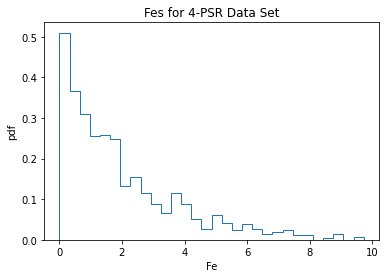

In [79]:
twofes = [2* f for f in fes]
n, bins, patches = plt.hist(twofes, bins=30, histtype='step', density=True)
plt.title("Fes for 4-PSR Data Set")
plt.xlabel("Fe")
plt.ylabel("pdf")
midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = n

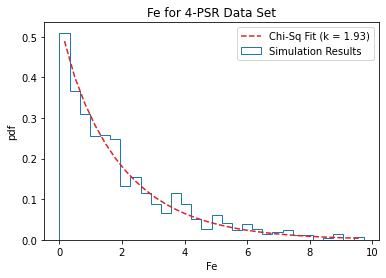

In [81]:
popt, pcov = curve_fit(chisq, midpts, counts,)

opt_k = popt[0]

n, bins, patches = plt.hist(twofes, bins=30, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(chisq(pt, k = opt_k))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.title("Fe for {}-PSR Data Set".format(4))
plt.legend(loc='upper right')
plt.xlabel("Fe")
plt.ylabel("pdf")
plt.show()
plt.close()

# WN and BWM data set

In [6]:
import pickle
import numpy as np

nano12p5_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12p5_pkl, 'rb') as pklin:
    allpsrs = pickle.load(pklin)
    
testpsr = allpsrs[0]
psrnames = [p.name for p in allpsrs[0:4]]

In [7]:
# We know the injected WN values
fake_noisedict = {}
for psrname in psrnames:
    fake_noisedict['{}_efac'.format(psrname)] = 1.0
    fake_noisedict['{}_log10_equad'.format(psrname)] = np.log10(100e-9)

In [43]:
fes_signal_secnotmjd = []

In [44]:
from enterprise.pulsar import Pulsar


partim_dir = '/home/nima/nanograv/bwm_fpfe/sandbox/'

burst_epoch = (53000 + 365.25*6)*24*3600
for realization in range(1, 801):
    realization_psrs = []
    for psrname in psrnames:
        parfile = partim_dir + '/WN_BWM_4psr_sims_LT_{}/{}_fake.par'.format(realization, psrname)
        timfile = partim_dir + '/WN_BWM_4psr_sims_LT_{}/{}_fake.tim'.format(realization, psrname)
        
        realization_psrs.append(Pulsar(parfile,timfile))
    realization_FeStat = FeStat(realization_psrs,params=fake_noisedict)
    fes_signal_secnotmjd.append(realization_FeStat.compute_Fe_bwm(t0_mjd = burst_epoch, gw_skylocs=np.array([[0,0]]))[0])


OSError: Cannot find parfile /home/nima/nanograv/bwm_fpfe/sandbox//WN_BWM_4psr_sims_LT_800/B1855+09_fake.par or timfile /home/nima/nanograv/bwm_fpfe/sandbox//WN_BWM_4psr_sims_LT_800/B1855+09_fake.tim!

We can parallelize

In [ ]:
# def festat_worker(realization_idx):
#     psrnames = [p.name for p in allpsrs[0:4]]
#     realization_psrs = []
#     print(realization_idx)
#     for psrname in psrnames:
#         parfile = partim_dir + '/WN_BWM_4psr_sims_LT_{}/{}_fake.par'.format(realization, psrname)
#         timfile = partim_dir + '/WN_BWM_4psr_sims_LT_{}/{}_fake.tim'.format(realization, psrname)
        
#         realization_psrs.append(Pulsar(parfile,timfile))
#     realization_FeStat = FeStat(realization_psrs,params=fake_noisedict)
#     fes_signal_secnotmjd.append(realization_FeStat.compute_Fe_bwm(t0_mjd = burst_epoch, gw_skylocs=np.array([[0,0]]))[0])
    
#     return fes_signal_secnotmjd



In [ ]:
# import multiprocessing
# args = []
# for realization_idx in range(1, 56):
#     args.append([realization_idx])
    
# p = multiprocessing.Pool(processes=14)    
# parallel_festats = p.map(festat_worker, args)

In [ ]:
# parallel_festats

In [45]:
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
def chisq(x, k = 2):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, dof, nc):
    return stats.ncx2.pdf(x, dof, nc, loc=0, scale=1)

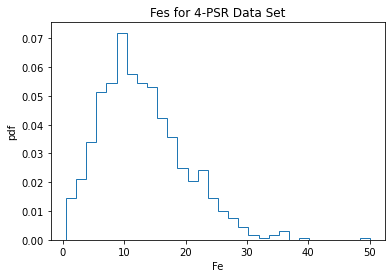

In [48]:
twofes_signal = [2* f for f in fes_signal_secnotmjd]
n, bins, patches = plt.hist(twofes_signal, bins=30, histtype='step', density=True)
plt.title("Fes for 4-PSR Data Set")
plt.xlabel("Fe")
plt.ylabel("pdf")
midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = n

In [65]:
import scipy.stats as spst
def nc_chisq_cdf_wrapper(x, dof, nc):
    cdf = spst.ncx2.cdf
    return cdf(x, df=dof, nc=nc)

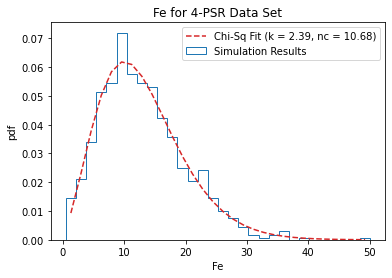

In [67]:
popt, pcov = curve_fit(nc_chisq_wrapper, midpts, counts,p0=[4,10],)

opt_k = popt[0]
opt_nc = popt[1]

n, bins, patches = plt.hist(twofes_signal, bins=30, histtype='step', cumulative=False, density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(nc_chisq_wrapper(pt, opt_k, opt_nc))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(opt_k, opt_nc))
plt.title("Fe for {}-PSR Data Set".format(4))
plt.legend(loc='upper right')
plt.xlabel("Fe")
plt.ylabel("pdf")
plt.show()
plt.close()